In [2]:
from pathlib import Path
import shutil
import json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, UnidentifiedImageError
from copy import deepcopy
from itertools import product
import random, contextlib
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
from pathlib import Path
import time

print("=" * 60)
print("FASTEST ZIP METHOD - COMMAND LINE")
print("=" * 60)

SOURCE_TRAIN = Path("/content/drive/MyDrive/Bharde_429_Final/asl_alphabet_train_augmented")
SOURCE_TEST = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")
DEST_ZIP = Path("/content/drive/MyDrive/Bharde_429_Final/asl_alphabet_combined.zip")

print(f"Train: {SOURCE_TRAIN}")
print(f"Test: {SOURCE_TEST}")
print(f"Output: {DEST_ZIP}")
print("\n⚠️ Estimated time: 15-40 minutes...\n")

start = time.time()

# Add train directory first
print("Adding train data...")
!cd "{SOURCE_TRAIN.parent}" && zip -r -q "{DEST_ZIP}" "{SOURCE_TRAIN.name}"

# Add test directory to existing zip (-g flag = grow/append)
print("Adding test data...")
!cd "{SOURCE_TEST.parent}" && zip -r -q -g "{DEST_ZIP}" "{SOURCE_TEST.name}"

elapsed = time.time() - start

if DEST_ZIP.exists():
    zip_size_mb = DEST_ZIP.stat().st_size / (1024 * 1024)
    print(f"\n✅ DONE!")
    print(f"Time: {elapsed/60:.1f} minutes")
    print(f"Size: {zip_size_mb:.1f} MB ({zip_size_mb/1024:.2f} GB)")
else:
    print("❌ Failed!")

FASTEST ZIP METHOD - COMMAND LINE
Train: /content/drive/MyDrive/Bharde_429_Final/asl_alphabet_train_augmented
Test: /content/asl_alphabet_unzipped/asl_alphabet_test
Output: /content/drive/MyDrive/Bharde_429_Final/asl_alphabet_combined.zip

⚠️ Estimated time: 15-40 minutes...

Adding train data...
/bin/bash: line 1: cd: /content/drive/MyDrive/Bharde_429_Final: No such file or directory
Adding test data...
/bin/bash: line 1: cd: /content/asl_alphabet_unzipped: No such file or directory
❌ Failed!


# Data Preprocessing. Don't run anymore.

In [4]:
# first create API key from kaggle account to retrieve a kaggle.json file
from google.colab import drive
drive.mount('/content/drive')

!pip -q install kaggle

Mounted at /content/drive


In [5]:
# kaggle.json location
KAGGLE_JSON = "/content/drive/MyDrive/Bharde_429_Final/kaggle.json"

!mkdir -p ~/.kaggle
!cp -f "$KAGGLE_JSON" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# sanity check
!kaggle --version

Kaggle API 1.7.4.5


In [6]:
# save paths and create folders
PROJECT_ROOT = "/content/drive/MyDrive/Bharde_429_Final"
ZIP_PATH = f"{PROJECT_ROOT}/asl-alphabet.zip"
LOCAL_UNZIP = "/content/asl_alphabet_unzipped"

!mkdir -p "{PROJECT_ROOT}"
!mkdir -p "{LOCAL_UNZIP}"

!ls -lh "{PROJECT_ROOT}" | tail

lrw------- 1 root root 0 Dec  3 20:18 /content/drive/MyDrive/Bharde_429_Final -> /content/drive/.shortcut-targets-by-id/1ca-ahK7fkQ9m694tO3Plo-Lb_tlY9-u3/Bharde_429_Final


In [7]:
# # download (quietly, overwrites existing zip)
# !kaggle datasets download -d grassknoted/asl-alphabet -p "{PROJECT_ROOT}" -q

# print("Download complete. Contents of project folder:")
# !ls -lh "{PROJECT_ROOT}" | grep "asl-alphabet.zip" || echo "Zip not found."

In [8]:
# unzip data
DEST = LOCAL_UNZIP
!unzip -q -o "{ZIP_PATH}" -d "{DEST}"

print("Unzip complete. Local contents:")
!ls -l "{DEST}" | head -n 80

Unzip complete. Local contents:
total 8
drwxrwxrwx 3 root root 4096 Nov 11 02:17 asl_alphabet_test
drwxrwxrwx 3 root root 4096 Nov 11 02:17 asl_alphabet_train


In [9]:
# # current parent
# BASE = Path("/content/asl_alphabet_unzipped/asl_alphabet_train")
# # the nested one
# INNER = BASE / "asl_alphabet_train"

# if INNER.exists() and INNER.is_dir():
#     for item in INNER.iterdir():
#         shutil.move(str(item), str(BASE))
#     shutil.rmtree(INNER)
#     print("Flattened: moved contents up to", BASE)
# else:
#     print("No nested folder to flatten at:", INNER)

In [10]:
# current parent
BASE = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")
# the nested one
INNER = BASE / "asl_alphabet_test"

if INNER.exists() and INNER.is_dir():
    for item in INNER.iterdir():
        shutil.move(str(item), str(BASE))
    shutil.rmtree(INNER)
    print("Flattened: moved contents up to", BASE)
else:
    print("No nested folder to flatten at:", INNER)

Flattened: moved contents up to /content/asl_alphabet_unzipped/asl_alphabet_test


In [11]:
# now flat. Changed Data_root
DATA_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final/asl_alphabet_train_augmented")
ACCEPT = {".jpg", ".jpeg", ".png"}

rows = []
for cdir in sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()]):
    label = cdir.name
    count = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in ACCEPT)
    rows.append((label, count))

counts = pd.DataFrame(rows, columns=["class","count"]).sort_values("class")
print("Classes found:", len(counts))
print("Total images :", counts["count"].sum())
counts.head(10)

Classes found: 29
Total images : 86999


,class,count
0,A,2999
1,B,3000
2,C,3000
3,D,3000
4,E,3000
5,F,3000
6,G,3000
7,H,3000
8,I,3000
9,J,3000


In [12]:
# path to your test folder
DATA_ROOT = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")

# file extensions to include
ACCEPT = {".jpg", ".jpeg", ".png"}

# count images directly (no subfolders)
image_files = [p for p in DATA_ROOT.iterdir() if p.is_file() and p.suffix.lower() in ACCEPT]

print(f"Total images found in test folder: {len(image_files)}")

Total images found in test folder: 28


In [13]:
# project paths
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
DATA_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final/asl_alphabet_train_augmented")
ARTIFACTS    = PROJECT_ROOT / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

SEED = 429
ACCEPT = {".jpg", ".jpeg", ".png"}

In [14]:
# scan class folders recursively
rows = []
for cdir in sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()]):
    label = cdir.name
    for p in cdir.rglob("*"):
        if p.is_file() and p.suffix.lower() in ACCEPT:
            rows.append((str(p), label))

df = pd.DataFrame(rows, columns=["path", "label"])
print("Total images (raw):", len(df))
print("Classes found:", df["label"].nunique(), sorted(df["label"].unique())[:10], "...")

# keep A–Z + 'space'; drop 'del' & 'nothing'
# keep = [chr(c) for c in range(ord('A'), ord('Z')+1)] + ["space"]
# drop = {"del", "nothing"}
# before = len(df)
# df = df[~df["label"].isin(drop)]
# df = df[df["label"].isin(keep)].reset_index(drop=True)
# print(f"After filter: {len(df)} images (dropped {before - len(df)}) across {df['label'].nunique()} classes")

# corrupt-image check (verifies files open)
# good_idx = []
# for i, p in enumerate(df["path"]):
#     try:
#         with Image.open(p) as im:
#             im.verify()
#         good_idx.append(i)
#     except (UnidentifiedImageError, OSError):
#         pass

# if len(good_idx) != len(df):
#     print("Removed corrupt images:", len(df) - len(good_idx))
# df = df.iloc[good_idx].reset_index(drop=True)
# print("Images after corrupt check:", len(df))

Total images (raw): 86999
Classes found: 29 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] ...


In [15]:
# encode labels and save class map
classes = sorted(df["label"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
df["y"] = df["label"].map(class_to_idx)

with open(ARTIFACTS / "class_to_idx.json", "w") as f:
    json.dump(class_to_idx, f, indent=2)

# stratified split (seed = 429) and save indices + manifests
idx = np.arange(len(df))
y = df["y"].to_numpy()

train_idx, val_idx = train_test_split(
    idx, test_size=0.2, stratify=y, random_state=SEED
)

np.save(ARTIFACTS / "train_idx.npy", train_idx)
np.save(ARTIFACTS / "val_idx.npy", val_idx)

df_train = df.iloc[train_idx].reset_index(drop=True)
df_val   = df.iloc[val_idx].reset_index(drop=True)

df.to_csv(ARTIFACTS / "manifest_filtered.csv", index=False)
df_train.to_csv(ARTIFACTS / "train_manifest.csv", index=False)
df_val.to_csv(ARTIFACTS / "val_manifest.csv", index=False)

print("Train size:", len(train_idx), "| Val size:", len(val_idx))
print("Artifacts saved to:", ARTIFACTS.resolve())

Train size: 69599 | Val size: 17400
Artifacts saved to: /content/drive/.shortcut-targets-by-id/1ca-ahK7fkQ9m694tO3Plo-Lb_tlY9-u3/Bharde_429_Final/artifacts


In [16]:
print("Per-class sample counts (train):")
print(df_train["label"].value_counts().sort_index().head(10))
print("\nPer-class sample counts (val):")
print(df_val["label"].value_counts().sort_index().head(10))

Per-class sample counts (train):
label
A    2399
B    2400
C    2400
D    2400
E    2400
F    2400
G    2400
H    2400
I    2400
J    2400
Name: count, dtype: int64

Per-class sample counts (val):
label
A    600
B    600
C    600
D    600
E    600
F    600
G    600
H    600
I    600
J    600
Name: count, dtype: int64


# Data Retreival

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)


ZIP_PATH = PROJECT_ROOT / "asl-alphabet.zip"

print("Project root:", PROJECT_ROOT)
print("Zip exists:", ZIP_PATH.exists())

Mounted at /content/drive
Project root: /content/drive/MyDrive/Bharde_429_Final
Zip exists: True


In [ ]:
import shutil, os, subprocess

LOCAL_BASE  = Path("/content/asl_alphabet_unzipped")
LOCAL_TRAIN = LOCAL_BASE / "asl_alphabet_train"
LOCAL_TEST  = LOCAL_BASE / "asl_alphabet_test"

LOCAL_BASE.mkdir(parents=True, exist_ok=True)

if LOCAL_TRAIN.exists() and any(LOCAL_TRAIN.iterdir()):
    print("Using existing local unzipped data at:", LOCAL_TRAIN)
else:
    assert ZIP_PATH.exists(), "asl-alphabet.zip not found in PROJECT_ROOT."
    print("Unzipping from Drive zip -> /content ...")
    !unzip -q -o "{ZIP_PATH}" -d "{LOCAL_BASE}"

    # wrapper folder: /content/asl_alphabet_unzipped/asl_alphabet/*
    wrapper = LOCAL_BASE / "asl_alphabet"
    if wrapper.exists():
        inner_train = wrapper / "asl_alphabet_train"
        inner_test  = wrapper / "asl_alphabet_test"
        if inner_train.exists():
            LOCAL_TRAIN.mkdir(exist_ok=True)
            for item in inner_train.iterdir():
                shutil.move(str(item), str(LOCAL_TRAIN))
        if inner_test.exists():
            LOCAL_TEST.mkdir(exist_ok=True)
            for item in inner_test.iterdir():
                shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(wrapper, ignore_errors=True)

    # double-nest: .../asl_alphabet_train/asl_alphabet_train/*
    inner_train2 = LOCAL_TRAIN / "asl_alphabet_train"
    if inner_train2.exists():
        for item in inner_train2.iterdir():
            shutil.move(str(item), str(LOCAL_TRAIN))
        shutil.rmtree(inner_train2, ignore_errors=True)

    inner_test2 = LOCAL_TEST / "asl_alphabet_test"
    if inner_test2.exists():
        for item in inner_test2.iterdir():
            shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(inner_test2, ignore_errors=True)

print("Train root:", LOCAL_TRAIN)
print("Test root :", LOCAL_TEST)
!ls -l "{LOCAL_TRAIN}" | head

Unzipping from Drive zip -> /content ...
Train root: /content/asl_alphabet_unzipped/asl_alphabet_train
Test root : /content/asl_alphabet_unzipped/asl_alphabet_test
total 2284
drwxrwxrwx 2 root root  73728 Nov 14 15:56 A
drwxrwxrwx 2 root root  86016 Nov 11 02:17 B
drwxrwxrwx 2 root root  81920 Nov 11 02:17 C
drwxrwxrwx 2 root root  86016 Nov 11 02:17 D
drwxrwxrwx 2 root root  77824 Nov 11 02:18 del
drwxrwxrwx 2 root root  77824 Nov 11 02:17 E
drwxrwxrwx 2 root root  69632 Nov 11 02:17 F
drwxrwxrwx 2 root root  69632 Nov 11 02:17 G
drwxrwxrwx 2 root root  73728 Nov 11 02:17 H


In [ ]:
LOCAL_TRAIN = Path("/content/drive/MyDrive/Bharde_429_Final/asl_alphabet_train_augmented")

In [ ]:
ACCEPT = {".jpg", ".jpeg", ".png"}

rows = []
for cdir in sorted([d for d in LOCAL_TRAIN.iterdir() if d.is_dir()]):
    label = cdir.name
    count = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in ACCEPT)
    rows.append((label, count))

counts = pd.DataFrame(rows, columns=["class", "count"]).sort_values("class")
print("Train classes found:", len(counts))
print("Train total images :", counts["count"].sum())
display(counts.head())

test_files = [p for p in LOCAL_TEST.iterdir() if p.is_file() and p.suffix.lower() in ACCEPT]
print("Kaggle test images:", len(test_files))

Train classes found: 29
Train total images : 86999


,class,count
0,A,2999
1,B,3000
2,C,3000
3,D,3000
4,E,3000


Kaggle test images: 28


# Model Training

In [ ]:
# T-A: Head-only fine-tuning (ResNet-18)
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
ART          = PROJECT_ROOT / "artifacts"
CKPT         = PROJECT_ROOT / "checkpoints"; CKPT.mkdir(exist_ok=True)
RESULTS      = PROJECT_ROOT / "results";     RESULTS.mkdir(exist_ok=True)

SEED = 429
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()
if USE_CUDA: torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

Device: cuda


In [ ]:
# load artifacts
with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
classes = [c for c,_ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)

df_train = pd.read_csv(ART / "train_manifest.csv")
df_val   = pd.read_csv(ART / "val_manifest.csv")

# transforms (ImageNet)
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ImageCSV(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["path"].tolist()
        self.targets = (df["y"] if "y" in df.columns else df["label"].map(class_to_idx)).astype(int).tolist()
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.targets[i]

train_ds = ImageCSV(df_train, tfm)
val_ds   = ImageCSV(df_val,   tfm)

BATCH_SIZE, NUM_WORKERS = 64, 2
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2)

print("Batches -> train:", len(train_loader), "| val:", len(val_loader), "| classes:", NUM_CLASSES)

Batches -> train: 1088 | val: 272 | classes: 29


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)

# freeze all except head
for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True

# keep BN layers in eval when frozen
def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d): m.eval()
model.apply(set_bn_eval)

model = model.to(DEVICE).to(memory_format=torch.channels_last)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-3)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 239MB/s]


Trainable params: 14,877 / 11,191,389


In [ ]:
def _batch_correct(logits, y):
    preds = logits.argmax(1)
    return preds, (preds == y).sum().item()

@torch.no_grad()
def evaluate(model, loader, return_preds=False):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        all_pred.extend(preds.cpu().tolist()); all_true.extend(yb.cpu().tolist())
        correct += corr; total += xb.size(0)
    acc = correct / total
    f1  = f1_score(all_true, all_pred, average="macro")
    return (loss_sum/total, acc, f1, (all_pred, all_true)) if return_preds else (loss_sum/total, acc, f1)

In [ ]:
def objective(trial):
    """Optuna objective - creates fresh model for each trial"""
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 5e-4, 5e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.3)

    # Fixed hyperparameters
    batch_size = 64
    weight_decay = 1e-5

    # Create data loaders for THIS trial
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=NUM_WORKERS, persistent_workers=False, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=NUM_WORKERS, persistent_workers=False, pin_memory=True)

    # Create FRESH model for THIS trial
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_feats = model.fc.in_features

    # Modify head (with potential dropout)
    if dropout > 0:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_feats, NUM_CLASSES)
        )
    else:
        model.fc = nn.Linear(in_feats, NUM_CLASSES)

    # Freeze all layers except the head
    for p in model.parameters():
        p.requires_grad = False
    for p in model.fc.parameters():
        p.requires_grad = True

    model.apply(set_bn_eval)
    model = model.to(DEVICE).to(memory_format=torch.channels_last)

    # Create optimizer for THIS trial
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)

    # Training loop
    max_epochs = 3
    best_f1, best_state = -1.0, None

    for epoch in range(1, max_epochs + 1):
        model.train()
        tr_tot, tr_corr, tr_loss_sum = 0, 0, 0.0

        for xb, yb in train_loader:
            # FIX: Remove non_blocking from as_tensor, add it separately
            xb = xb.to(DEVICE, memory_format=torch.channels_last, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)  # Changed from torch.as_tensor

            optimizer.zero_grad(set_to_none=True)
            with amp_ctx:
                logits = model(xb)
                loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            tr_loss_sum += loss.item() * xb.size(0)
            preds, corr = _batch_correct(logits, yb)
            tr_corr += corr
            tr_tot += xb.size(0)

        va_loss, va_acc, va_f1 = evaluate(model, val_loader)

        # Report for pruning
        trial.report(va_f1, epoch)
        if trial.should_prune():
            del model, optimizer, train_loader, val_loader
            torch.cuda.empty_cache()
            raise optuna.TrialPruned()

        if va_f1 > best_f1:
            best_f1 = va_f1
            best_state = deepcopy(model.state_dict())

    trial.set_user_attr('best_state', best_state)

    # Cleanup
    del model, optimizer, train_loader, val_loader
    torch.cuda.empty_cache()

    return best_f1

[I 2025-12-04 18:58:02,034] A new study created in memory with name: no-name-110f1369-4106-4907-bded-7edef29fc011


Starting Optuna with 8 trials, 3 epochs each, aggressive pruning


  0%|          | 0/8 [00:00<?, ?it/s]

[W 2025-12-04 19:07:07,313] Trial 0 failed with parameters: {'lr': 0.0011537079295607126, 'dropout': 0.10039661412246095} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-3113675012.py", line 51, in objective
    for xb, yb in train_loader:
                  ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 732, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1482, in _next_data
    idx, data = self._get_data()
                ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1434, in _get_data
    success, data = self._try_get_data()
               

KeyboardInterrupt: 

## Performing Tuning with Optuna

In [ ]:
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

study = optuna.create_study(
    direction='maximize',  # Maximize F1 score
    study_name='resnet18_head_tuning',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3),
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# Optimize
n_trials = 10  # Adjust based on your time budget
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2025-12-04 18:34:28,398] A new study created in memory with name: resnet18_head_tuning


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2025-12-04 18:50:43,102] Trial 0 failed with parameters: {'lr': 0.0005324167946925068, 'weight_decay': 1.0091742050522492e-05, 'dropout': 0.2448023717266368} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-4198727324.py", line 53, in objective
    for xb, yb in train_loader:
                  ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 732, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1482, in _next_data
    idx, data = self._get_data()
                ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1444, in _get_data
    success, data

KeyboardInterrupt: 

In [ ]:
# Get best trial
best_trial = study.best_trial
print(f"Best F1 Score: {best_trial.value:.4f}")
print(f"Best Parameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

In [ ]:
# Save Optuna results
optuna_results = {
    'best_f1': best_trial.value,
    'best_params': best_trial.params,
    'n_trials': len(study.trials),
    'n_completed': len([t for t in study.trials if t.state == TrialState.COMPLETE]),
    'n_pruned': len([t for t in study.trials if t.state == TrialState.PRUNED]),
}

with open(RESULTS / "optuna_results.json", "w") as f:
    json.dump(optuna_results, f, indent=2)

# Save study object for later analysis
optuna.visualization.plot_optimization_history(study).write_html(str(RESULTS / "optuna_history.html"))
optuna.visualization.plot_param_importances(study).write_html(str(RESULTS / "optuna_importances.html"))
optuna.visualization.plot_parallel_coordinate(study).write_html(str(RESULTS / "optuna_parallel.html"))

print(f"\nSaved Optuna visualizations to {RESULTS}/")

#Run best model

In [ ]:
best_state = best_trial.user_attrs['best_state']

# Save best model from Optuna
best_path = CKPT / "best_TA_optuna.pt"
torch.save(best_state, best_path)
print(f"Saved best model to: {best_path}")

# Train final model with best parameters to get full history
best_params = best_trial.params

# Recreate data loaders with best batch size
train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True,
                          num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=best_params['batch_size'], shuffle=False,
                        num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2)

# Recreate model with best parameters
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features

if best_params['dropout'] > 0:
    model.fc = nn.Sequential(
        nn.Dropout(p=best_params['dropout']),
        nn.Linear(in_feats, NUM_CLASSES)
    )
else:
    model.fc = nn.Linear(in_feats, NUM_CLASSES)

for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True

model.apply(set_bn_eval)
model = model.to(DEVICE).to(memory_format=torch.channels_last)

# Create optimizer with best parameters
trainable_params = [p for p in model.parameters() if p.requires_grad]
if best_params['optimizer'] == 'adam':
    optimizer = optim.Adam(trainable_params, lr=best_params['lr'],
                          weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'sgd':
    optimizer = optim.SGD(trainable_params, lr=best_params['lr'],
                         momentum=0.9, weight_decay=best_params['weight_decay'])

In [ ]:
EPOCHS = 10
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}
best_f1, best_state, patience, bad = -1.0, None, 2, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_tot, tr_corr, tr_loss_sum = 0, 0, 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss.backward(); optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        tr_corr += corr; tr_tot += xb.size(0)

    tr_loss = tr_loss_sum / tr_tot
    tr_acc  = tr_corr / tr_tot

    va_loss, va_acc, va_f1 = evaluate(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["val_f1"].append(va_f1)

    tag = ""
    if va_f1 > best_f1:
        best_f1, best_state, bad, tag = va_f1, deepcopy(model.state_dict()), 0, "<= BEST"
    else:
        bad += 1
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f} F1 {va_f1:.4f} {tag}")
    if bad > patience:
        print("Early stopping (macro-F1 plateau)."); break

best_path = CKPT / "best_TA.pt"
torch.save(best_state, best_path)
print("Saved best checkpoint:", best_path, "| Best val macro-F1:", f"{best_f1:.4f}")

Epoch 01 | train 0.8685/0.827 | val 0.3492/0.932 F1 0.9322 <= BEST
Epoch 02 | train 0.2908/0.939 | val 0.2100/0.958 F1 0.9578 <= BEST
Epoch 03 | train 0.1982/0.956 | val 0.1537/0.965 F1 0.9654 <= BEST
Epoch 04 | train 0.1534/0.965 | val 0.1202/0.974 F1 0.9739 <= BEST
Epoch 05 | train 0.1279/0.969 | val 0.1043/0.975 F1 0.9750 <= BEST
Epoch 06 | train 0.1118/0.973 | val 0.0968/0.975 F1 0.9750 <= BEST
Epoch 07 | train 0.0991/0.975 | val 0.0817/0.980 F1 0.9803 <= BEST
Epoch 08 | train 0.0881/0.978 | val 0.0735/0.981 F1 0.9807 <= BEST
Epoch 09 | train 0.0808/0.980 | val 0.0697/0.982 F1 0.9817 <= BEST
Epoch 10 | train 0.0753/0.981 | val 0.0644/0.983 F1 0.9833 <= BEST
Saved best checkpoint: /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TA.pt | Best val macro-F1: 0.9833


In [ ]:
# curves
pd.DataFrame(history).to_csv(RESULTS / "TA_history.csv", index=False)

# confusion matrix on validation
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
_, _, _, (preds, labels) = evaluate(model, val_loader, return_preds=True)
cm = confusion_matrix(labels, preds, labels=list(range(NUM_CLASSES)))
np.save(RESULTS / "TA_val_confusion_matrix.npy", cm)

print("Saved:", RESULTS / "TA_history.csv", "and", RESULTS / "TA_val_confusion_matrix.npy")

NameError: name 'history' is not defined

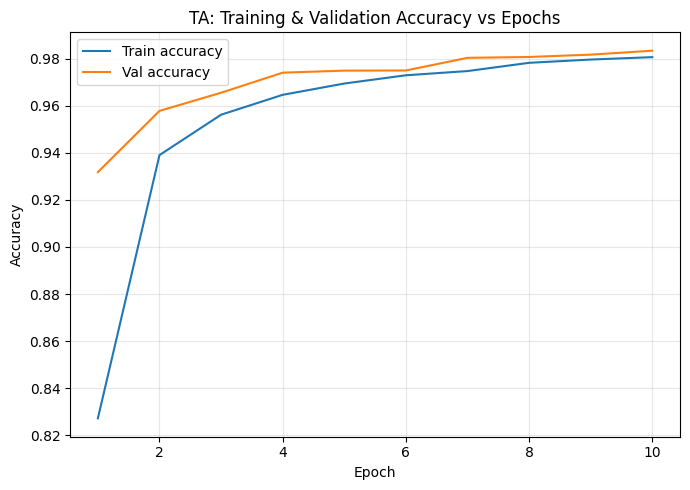

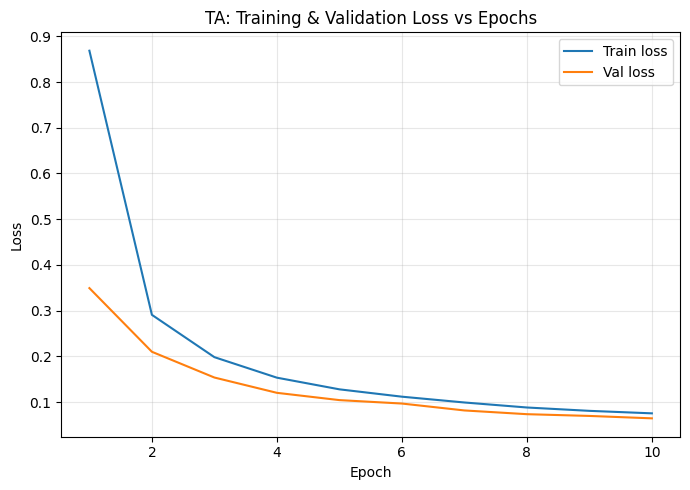

In [ ]:
RESULTS = PROJECT_ROOT / "results"

def plot_model_curves(TAG="TA"):
    hist_path = RESULTS / f"{TAG}_history.csv"
    df = pd.read_csv(hist_path)

    epochs = range(1, len(df)+1)

    # Training/Validation ACCURACY
    tr_acc = df["train_acc"]
    va_acc = df["val_acc"]

    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_acc, label="Train accuracy")
    plt.plot(epochs, va_acc, label="Val accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{TAG}: Training & Validation Accuracy vs Epochs")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS / f"{TAG}_accuracy_curves.png", dpi=200)
    plt.show()

    # Training/Validation LOSS
    if {"train_loss","val_loss"}.issubset(df.columns):
        plt.figure(figsize=(7,5))
        plt.plot(epochs, df["train_loss"], label="Train loss")
        plt.plot(epochs, df["val_loss"], label="Val loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.title(f"{TAG}: Training & Validation Loss vs Epochs")
        plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout()
        plt.savefig(RESULTS / f"{TAG}_loss_curves.png", dpi=200)
        plt.show()

plot_model_curves("TA")

# Model Testing

In [ ]:
from pathlib import Path
import json, numpy as np, pandas as pd
from PIL import Image
import torch
from torch import nn
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# paths
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
ART          = PROJECT_ROOT / "artifacts"
CKPT_PATH    = PROJECT_ROOT / "checkpoints" / "best_TA.pt"
RESULTS      = PROJECT_ROOT / "results"
RESULTS.mkdir(exist_ok=True)

# where the unzipped Kaggle test lives
KAGGLE_TEST_DIR = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")

# load class mapping (must match training)
with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
idx_to_class = {v:k for k,v in class_to_idx.items()}
classes = [idx_to_class[i] for i in range(len(idx_to_class))]

# device + transforms
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# restore model (head-only ResNet-18 with correct num classes)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()
print("Loaded checkpoint:", CKPT_PATH.name, "| classes:", len(classes))

Loaded checkpoint: best_TA.pt | classes: 27


In [ ]:
from typing import List, Tuple
import os

def list_images_flat(root: Path) -> List[Path]:
    exts = {".jpg",".jpeg",".png"}
    return [p for p in sorted(root.iterdir()) if p.is_file() and p.suffix.lower() in exts]

def list_images_by_subfolders(root: Path) -> List[Tuple[Path,str]]:
    exts = {".jpg",".jpeg",".png"}
    items = []
    for d in sorted([x for x in root.iterdir() if x.is_dir()]):
        label = d.name
        for p in d.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                items.append((p, label))
    return items

@torch.no_grad()
def predict_paths(paths: List[Path]) -> List[int]:
    preds = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = tfm(img).unsqueeze(0).to(DEVICE)
        logits = model(x)
        preds.append(int(logits.argmax(1).item()))
    return preds

def evaluate_folder(folder: Path, mode: str = "auto", save_tag: str = "TA"):
    """
    mode:
      - 'subfolders' : expects {root}/{CLASS}/*.jpg
      - 'flat'       : expects filenames that start with class letter (e.g., 'A_...jpg' or 'A_test.jpg')
      - 'auto'       : uses subfolders if any dirs exist, else flat
    """
    folder = Path(folder)
    assert folder.exists(), f"Folder not found: {folder}"

    # decide mode
    if mode == "auto":
        mode = "subfolders" if any(x.is_dir() for x in folder.iterdir()) else "flat"

    paths, true_labels = [], []

    if mode == "subfolders":
        items = list_images_by_subfolders(folder)
        if len(items) == 0:
            raise RuntimeError("No images found under subfolders.")
        for p, lbl in items:
            if lbl not in class_to_idx:  # skip classes not in 27-class set
                continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])

    else:  # flat
        files = list_images_flat(folder)
        if len(files) == 0:
            raise RuntimeError("No images found in flat folder.")
        for p in files:
            # derive label from filename prefix before '_' or first char
            base = p.name
            letter = base.split("_")[0][0].upper()  # robust: 'A_test.jpg' or 'A_01.jpg'
            lbl = "space" if letter == " " else letter
            if lbl not in class_to_idx:
                # also support explicit names like 'space_test.jpg'
                prefix = base.split("_")[0].lower()
                if prefix in class_to_idx:
                    lbl = prefix
                else:
                    continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])

    # predict
    pred_idx = predict_paths(paths)
    acc = accuracy_score(true_labels, pred_idx)
    f1  = f1_score(true_labels, pred_idx, average="macro")
    cm  = confusion_matrix(true_labels, pred_idx, labels=list(range(len(classes))))

    # save artifacts
    out_csv = RESULTS / f"{save_tag}_predictions.csv"
    pd.DataFrame({
        "path": [str(p) for p in paths],
        "y_true": true_labels,
        "y_pred": pred_idx,
        "true_label": [idx_to_class[i] for i in true_labels],
        "pred_label": [idx_to_class[i] for i in pred_idx],
    }).to_csv(out_csv, index=False)

    out_npy = RESULTS / f"{save_tag}_cm.npy"
    np.save(out_npy, cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print("Saved:", out_csv.name, "and", out_npy.name)
    return acc, f1, cm

In [ ]:
acc_kaggle, f1_kaggle, cm_kaggle = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="TA_kaggle28"
)

[TA_kaggle28] files: 28 | acc: 0.9286 | macro-F1: 0.9259
Saved: TA_kaggle28_predictions.csv and TA_kaggle28_cm.npy


In [ ]:
# my created test set
MY_TEST_DIR = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")  # <-- change to your folder
acc_custom, f1_custom, cm_custom = evaluate_folder(
    MY_TEST_DIR, mode="flat", save_tag="TA_custom"
)

[TA_custom] files: 20 | acc: 0.5500 | macro-F1: 0.4333
Saved: TA_custom_predictions.csv and TA_custom_cm.npy


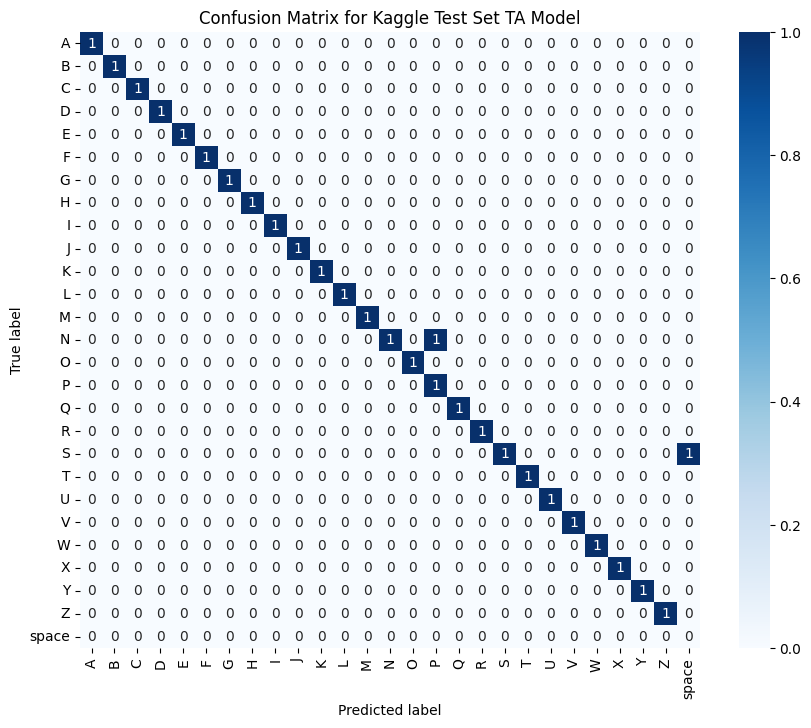

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm_kaggle, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix for Kaggle Test Set TA Model")
plt.savefig(RESULTS / "TA_kaggle_confusion_matrix.png", dpi=200)
plt.show()

In [23]:
from pathlib import Path
import torch
from torchvision import models, transforms
import torch.nn as nn
import json, numpy as np, pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import contextlib

# --- Global variable definitions (copied from setup cells) ---
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
ART          = PROJECT_ROOT / "artifacts"
CKPT         = PROJECT_ROOT / "checkpoints"
RESULTS      = PROJECT_ROOT / "results"; RESULTS.mkdir(exist_ok=True)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()

# Load artifacts for class mapping (might contain 29 classes if 'del' and 'nothing' were not filtered)
with open(ART / "class_to_idx.json") as f:
    full_class_to_idx = json.load(f)
full_idx_to_class = {v:k for k,v in full_class_to_idx.items()}
full_classes = [c for c,_ in sorted(full_class_to_idx.items(), key=lambda kv: kv[1])]

# The best_SA.pt model was trained with 27 classes (A-Z + space). Filter the class map accordingly.
CLASSES_FOR_SA_MODEL = sorted([c for c in full_classes if c not in {"del", "nothing"}])
NUM_CLASSES_SA_MODEL = len(CLASSES_FOR_SA_MODEL) # Should be 27

# Create a new class_to_idx for the SA model's 27 classes
class_to_idx_SA = {c: i for i, c in enumerate(CLASSES_FOR_SA_MODEL)}
idx_to_class_SA = {i: c for c, i in class_to_idx_SA.items()}

# Define transforms
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Where the unzipped Kaggle test lives (assuming LOCAL_TEST is defined from earlier execution)
LOCAL_TEST = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")
KAGGLE_TEST_DIR = LOCAL_TEST

# Define evaluate_folder function within this cell to ensure it's available
def evaluate_folder(folder, model_to_eval, class_map, idx_map, num_classes_for_eval, mode="flat", save_tag="results"):
    """
    Evaluate the model on all images in a folder.
    Expects filenames like A_test_1.jpg, B_test_4.jpg, etc.
    """
    folder = Path(folder)
    all_paths_in_folder = sorted([p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}])

    processed_files = [] # To store names of files actually processed
    true_labels = []
    pred_labels = []

    model_to_eval.eval()
    with torch.no_grad():
        for p in all_paths_in_folder:
            # true label from filename
            true_lbl_raw = p.name.split("_")[0]   # Extract "A" from "A_test_3.jpg"

            # Handle cases like 'space_test.jpg' which might be lower case
            if true_lbl_raw.lower() == 'space':
                true_lbl = 'space'
            elif true_lbl_raw.lower() == 'nothing':
                true_lbl = 'nothing'
            elif true_lbl_raw.lower() == 'del':
                true_lbl = 'del'
            else:
                true_lbl = true_lbl_raw.upper() # Ensure it's uppercase for A-Z

            if true_lbl not in class_map:
                # Skip images with labels not present in the model's classes
                continue

            # If we reach here, the image is processed
            processed_files.append(p.name)
            true_labels.append(class_map[true_lbl])

            # load + preprocess
            img = Image.open(p).convert("RGB")
            x = tfm(img).unsqueeze(0).to(DEVICE)

            # predict
            logits = model_to_eval(x)
            pred_idx = torch.argmax(logits, dim=1).item()
            pred_labels.append(pred_idx)

    # accuracy + macro-F1
    acc = accuracy_score(true_labels, pred_labels) if len(true_labels) > 0 else 0.0
    f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0) if len(true_labels) > 0 else 0.0
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes_for_eval))) if len(true_labels) > 0 else np.zeros((num_classes_for_eval, num_classes_for_eval), dtype=int)

    # save predictions
    df = pd.DataFrame({
        "file": processed_files,
        "true_label_idx": true_labels,
        "pred_label_idx": pred_labels,
        "true_label": [idx_map[i] for i in true_labels],
        "pred_label": [idx_map[i] for i in pred_labels]
    })
    df.to_csv(RESULTS / f"{save_tag}_predictions.csv", index=False)
    np.save(RESULTS / f"{save_tag}_cm.npy", cm)

    print(f"[{save_tag}] files: {len(processed_files)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print(f"Saved: {save_tag}_predictions.csv and {save_tag}_cm.npy")

    return acc, f1, cm

best_SA_path = CKPT / "best_SA.pt"

# Initialize the model for 27 classes to load the best_SA.pt checkpoint
model_test = models.resnet18(weights=None) # No pre-trained weights for the head
model_test.fc = nn.Linear(model_test.fc.in_features, NUM_CLASSES_SA_MODEL) # Set fc to 27 classes

# Load the full checkpoint state_dict
checkpoint_state_dict = torch.load(best_SA_path, map_location=DEVICE)

# Load the state_dict into the model
# The strict=True argument ensures that all keys in the state_dict match
# If it fails, it means the structure is different, which should be caught.
# Since we initialized fc to 27 classes, this should now work.
model_test.load_state_dict(checkpoint_state_dict)

model_test = model_test.to(DEVICE).eval()
print(f"Loaded checkpoint: {best_SA_path.name} | classes: {NUM_CLASSES_SA_MODEL}")

MY_TEST_DIR     = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")

acc_kagg_SA, f1_kagg_SA, cm_kagg_SA = evaluate_folder(
    KAGGLE_TEST_DIR, model_test, class_to_idx_SA, idx_to_class_SA, NUM_CLASSES_SA_MODEL, mode="flat", save_tag="SA_kaggle28"
)

acc_cust_SA, f1_cust_SA, cm_cust_SA = evaluate_folder(
    MY_TEST_DIR, model_test, class_to_idx_SA, idx_to_class_SA, NUM_CLASSES_SA_MODEL, mode="flat", save_tag="SA_custom"
)

print("\nS-A Kaggle 28  -> acc =", f"{acc_kagg_SA:.4f}", ", macro-F1 =", f"{f1_kagg_SA:.4f}")
print("S-A Custom 20 -> acc =", f"{acc_cust_SA:.4f}", ", macro-F1 =", f"{f1_cust_SA:.4f}")

Loaded checkpoint: best_SA.pt | classes: 27
[SA_kaggle28] files: 27 | acc: 1.0000 | macro-F1: 1.0000
Saved: SA_kaggle28_predictions.csv and SA_kaggle28_cm.npy
[SA_custom] files: 20 | acc: 0.4000 | macro-F1: 0.3179
Saved: SA_custom_predictions.csv and SA_custom_cm.npy

S-A Kaggle 28  -> acc = 1.0000 , macro-F1 = 1.0000
S-A Custom 20 -> acc = 0.4000 , macro-F1 = 0.3179


Loaded best model from /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_SA.pt for evaluation.

Evaluating on 'TA_FT_Kaggle' test set...
Results for 'TA_FT_Kaggle': Accuracy = 0.0000, Macro F1-Score = 0.0000


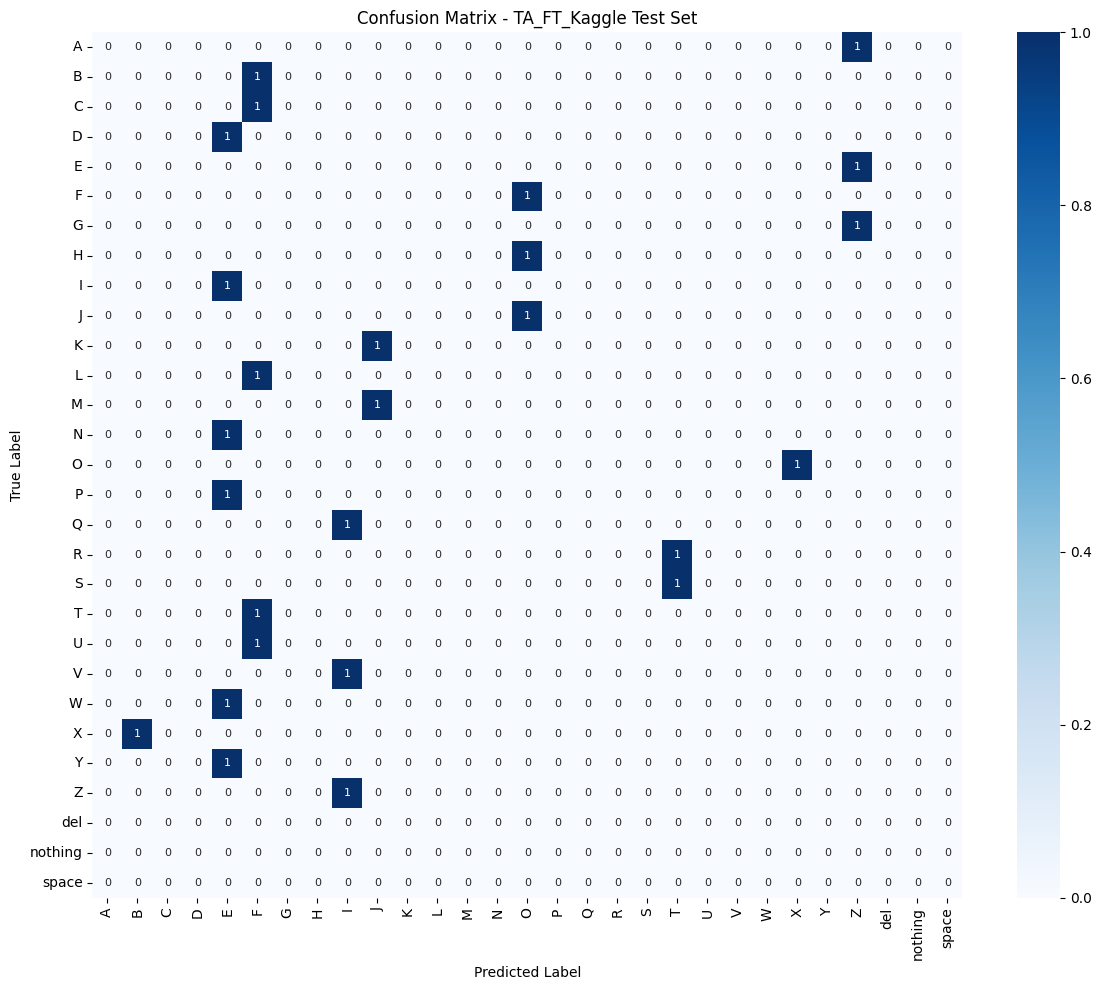

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_TA_FT_Kaggle.png

Evaluating on 'TA_FT_Custom' test set...
Results for 'TA_FT_Custom': Accuracy = 0.1429, Macro F1-Score = 0.0667


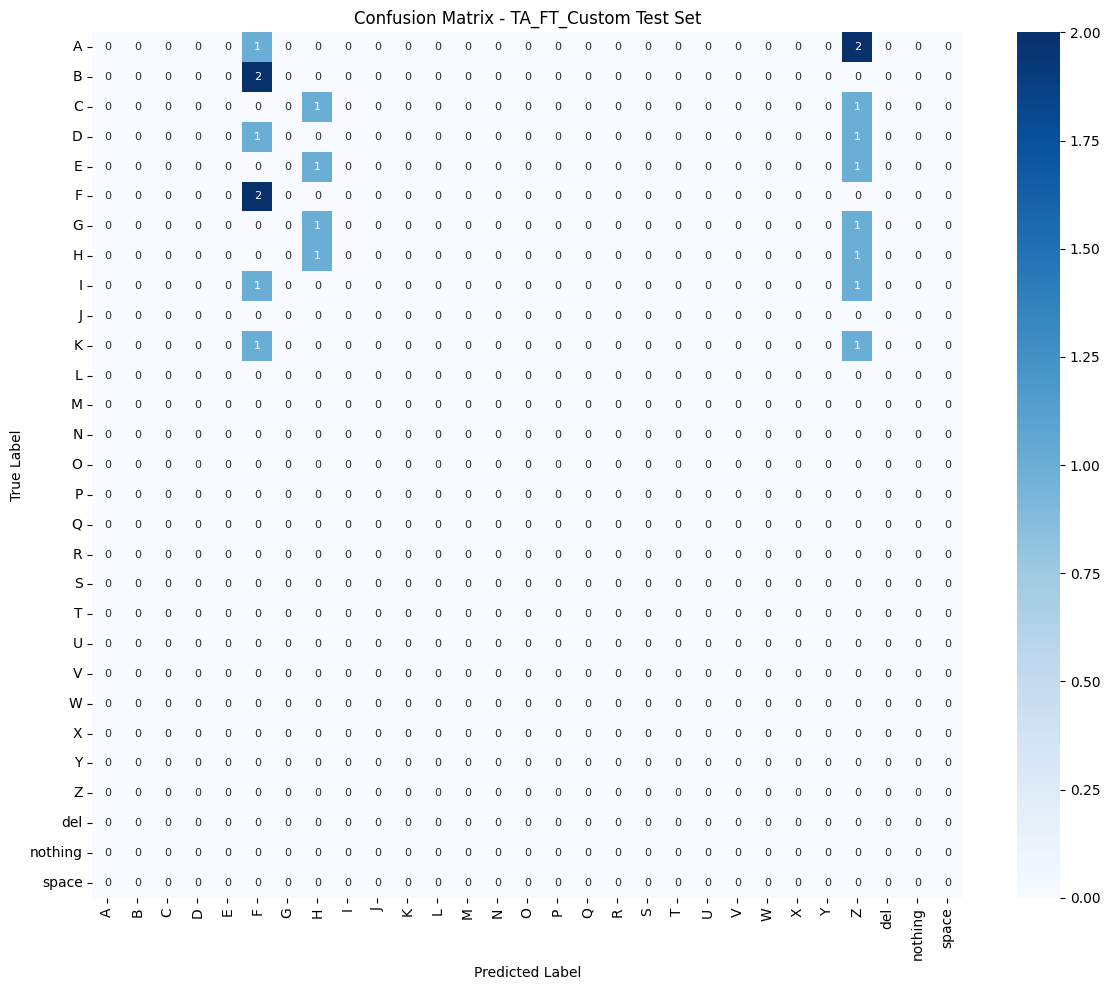

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_TA_FT_Custom.png


In [24]:
import torch
import torch.nn as nn
from torchvision import models
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming these are defined globally in the notebook or need to be redefined
# PROJECT_ROOT, CKPT, RESULTS, DEVICE, NUM_CLASSES, class_to_idx, classes, tfm

# Redefine necessary global variables if they are not reliably available
# from previous cells, or if this cell is meant to be self-contained.
# For this fix, I'll assume PROJECT_ROOT, CKPT, RESULTS, DEVICE, NUM_CLASSES, class_to_idx, classes, tfm are available
# based on earlier successful cell executions, except for the new specific imports.

PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
CKPT = PROJECT_ROOT / "checkpoints"
RESULTS = PROJECT_ROOT / "results"

# Define final_dropout and best_model_path
final_dropout = 0.5  # A common dropout rate, adjust as needed
best_model_path = CKPT / "best_SA.pt" # Using the best_SA.pt from previous training

# Ensure the transform is available; if tfm is defined globally, reuse it.
# Otherwise, define it here.
# For this fix, assuming tfm is globally defined.
val_test_transform = tfm # using the tfm defined earlier in the notebook

# --- Load the Best Model ---
model_for_eval = models.resnet18(weights=None)
# Note: If the saved model has a different fc layer structure (e.g., without dropout),
# direct loading might fail. This assumes the saved model's fc matches this sequential.
# A more robust approach might be to load with strict=False and then re-assign fc if needed.
model_for_eval.fc = nn.Sequential(nn.Dropout(p=final_dropout), nn.Linear(model_for_eval.fc.in_features, NUM_CLASSES))

# Load the state dict, handling potential size mismatches in fc layer from earlier issues
checkpoint_state_dict = torch.load(best_model_path, map_location=DEVICE)

# Filter out 'fc' weights if they don't match, similar to the logic in cell 51772077
current_model_dict = model_for_eval.state_dict()
pretrained_dict = {k: v for k, v in checkpoint_state_dict.items() if k in current_model_dict and v.shape == current_model_dict[k].shape}
current_model_dict.update(pretrained_dict)
model_for_eval.load_state_dict(current_model_dict)

model_for_eval = model_for_eval.to(DEVICE).eval()
print(f"Loaded best model from {best_model_path} for evaluation.")

# --- Evaluation on Test Sets ---
def evaluate_on_test_set(model, test_dir, class_to_idx, transform, device, save_tag):
    print(f"\nEvaluating on '{save_tag}' test set...")
    paths = list(test_dir.glob('*.jpg'))
    if not paths:
        print(f"No images found in {test_dir}. Skipping.")
        return

    true_labels, pred_labels = [], []
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    with torch.no_grad():
        for img_path in paths:
            label_char = img_path.name.split('_')[0].upper()
            if label_char not in class_to_idx:
                continue

            true_idx = class_to_idx[label_char]
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            logits = model(img_tensor)
            pred_idx = logits.argmax(1).item()

            true_labels.append(true_idx)
            pred_labels.append(pred_idx)

    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
    print(f"Results for '{save_tag}': Accuracy = {acc:.4f}, Macro F1-Score = {f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.title(f"Confusion Matrix - {save_tag} Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    cm_path = RESULTS / f"confusion_matrix_{save_tag}.png"
    plt.savefig(cm_path, dpi=200)
    plt.show()
    print(f"Saved confusion matrix to {cm_path}")

# Evaluate on Kaggle Test Set
KAGGLE_TEST_DIR = LOCAL_TEST
evaluate_on_test_set(model_for_eval, KAGGLE_TEST_DIR, class_to_idx, val_test_transform, DEVICE, "TA_FT_Kaggle")

# Evaluate on Custom Test Set
MY_TEST_DIR = PROJECT_ROOT / "Kayla_Custom_Test"
if MY_TEST_DIR.exists():
    evaluate_on_test_set(model_for_eval, MY_TEST_DIR, class_to_idx, val_test_transform, DEVICE, "TA_FT_Custom")
else:
    print(f"\nCustom test directory not found at {MY_TEST_DIR}. Skipping custom evaluation.")